# Evaluate new polynomial solution

In [1]:
import funcs
from distortionMaps import d2cMapping

import numpy as np
from datetime import date
from astropy.io import fits
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
# directories

# USER:
user = "yannis" # "alvaro","yannis"
# Set work directory
if user == "alvaro":
    workDir = "./"
if user == "yannis":
    workDir  = "/Users/ioannisa/Desktop/python/miri_devel/"

datadir = "data/"
cdpDir = workDir+"cdp_data/"

# analysis inputs
band = "2B"
etal = "ET1B" # "ET1A", "ET1B", "ET2A", "ET2B"
islice = 17

# load new wavelength solution
wavsolution_file   = 'data/Band'+str(band)+'_ET'+ etal[-2:] +'_slice'+str(islice)+'_coeffs.txt'
slice_wavcoeffs = np.loadtxt(wavsolution_file,unpack=True, skiprows = 5)

In [3]:
# load distortion maps
d2cMaps   = d2cMapping(band,cdpDir)
sliceMap  = d2cMaps['sliceMap']
lambdaMap = d2cMaps['lambdaMap']
alphaMap  = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']
det_dims  = (1024,1032)

# compute slice reference x-position
alpha_img = np.zeros(det_dims)
alpha_img[(sliceMap == 100*int(band[0])+islice)] = alphaMap[(sliceMap == 100*int(band[0])+islice)]
x_coords = np.nonzero(alpha_img[512,:])[0]
alphas = alpha_img[512,:][x_coords]
xs = interp1d(alphas,x_coords)(0.)

In [4]:
fileversion = "06.04.00"
distcdp = {}
distcdp["3C"] = "MIRI_FM_MIRIFULONG_34LONG_DISTORTION_%s.fits" %fileversion
distcdp["3B"] = "MIRI_FM_MIRIFULONG_34MEDIUM_DISTORTION_%s.fits" %fileversion
distcdp["3A"] = "MIRI_FM_MIRIFULONG_34SHORT_DISTORTION_%s.fits" %fileversion

distcdp["1C"] = "MIRI_FM_MIRIFUSHORT_12LONG_DISTORTION_%s.fits" %fileversion
distcdp["1B"] = "MIRI_FM_MIRIFUSHORT_12MEDIUM_DISTORTION_%s.fits" %fileversion
distcdp["1A"] = "MIRI_FM_MIRIFUSHORT_12SHORT_DISTORTION_%s.fits" %fileversion

distcdp["4C"] = distcdp["3C"]
distcdp["4B"] = distcdp["3B"]
distcdp["4A"] = distcdp["3A"]

distcdp["2C"] = distcdp["1C"]
distcdp["2B"] = distcdp["1B"]
distcdp["2A"] = distcdp["1A"]

In [5]:
band_distCDP = fits.open(cdpDir+distcdp[band])
slice_wavcoeffs_cdp = np.array(band_distCDP['Lambda_CH{}'.format(band[0])].data[islice-1])

In [6]:
print '------DISTORTION CDP version {}--------'.format(fileversion)
print 'Reference x-position: {}pix'.format(round(slice_wavcoeffs_cdp[0],2))
print '2D polynomial coefficients: {}'.format(slice_wavcoeffs_cdp[1:])
print ''
print '------NEW WAVECAL--------'
print 'Reference x-position: {}pix'.format(round(xs,2))
print '2D polynomial coefficients: {}'.format(slice_wavcoeffs)

------DISTORTION CDP version 06.04.00--------
Reference x-position: 957.31pix
2D polynomial coefficients: [  8.56649030e+00  -4.15360197e-04  -1.08765497e-06   3.20418157e-09
   1.26907470e-10   1.77379871e-03   3.47490044e-07  -1.88699553e-10
  -4.49500557e-11  -1.18644612e-12  -2.44143591e-07  -1.61870766e-10
   8.24386561e-14   1.74036958e-13   1.90445498e-15   5.20775958e-11
   2.04169743e-14  -6.78254994e-16  -2.26461994e-16  -9.14960286e-19
  -1.32477206e-14  -2.24550347e-17   4.75745661e-19   9.53829643e-20
   3.41756562e-24]

------NEW WAVECAL--------
Reference x-position: 961.62pix
2D polynomial coefficients: [  8.63051827e+00  -2.31803281e-04   2.44060631e-06   0.00000000e+00
   0.00000000e+00   1.77250233e-03  -2.01978680e-07  -1.45378077e-09
   0.00000000e+00   0.00000000e+00  -1.85219581e-07   2.09489761e-10
  -3.70294830e-13   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.0000000

In [7]:
channel = int(band[0])
new_lambdaMap  = np.zeros(sliceMap.shape)

for islice in range(1,nslices+1):
    # load new wavelength solution
    wavsolution_file   = 'data/Band'+str(band)+'_ET'+ etal[-2:] +'_slice'+str(islice)+'_coeffs.txt'
    slice_wavcoeffs = np.loadtxt(wavsolution_file,unpack=True,skiprows = 5)
    
    # create placeholder and identify pixels in slice
    pixelCtry,pixelCtrx = np.where(sliceMap == int(islice+100*channel))
    lambdas   = np.zeros(len(pixelCtry))
    
    # apply the 2D polynomial transform
    lp = slice_wavcoeffs
    # compute slice reference x-position
    alpha_img = np.zeros(det_dims)
    alpha_img[(sliceMap == 100*int(band[0])+islice)] = alphaMap[(sliceMap == 100*int(band[0])+islice)]
    x_coords = np.nonzero(alpha_img[512,:])[0]
    alphas = alpha_img[512,:][x_coords]
    xs = interp1d(alphas,x_coords)(0.)
    
    new_lambdaMap[pixelCtry,pixelCtrx]   = funcs.polyval2d(xs,pixelCtrx, pixelCtry, lp)

<IPython.core.display.Javascript object>


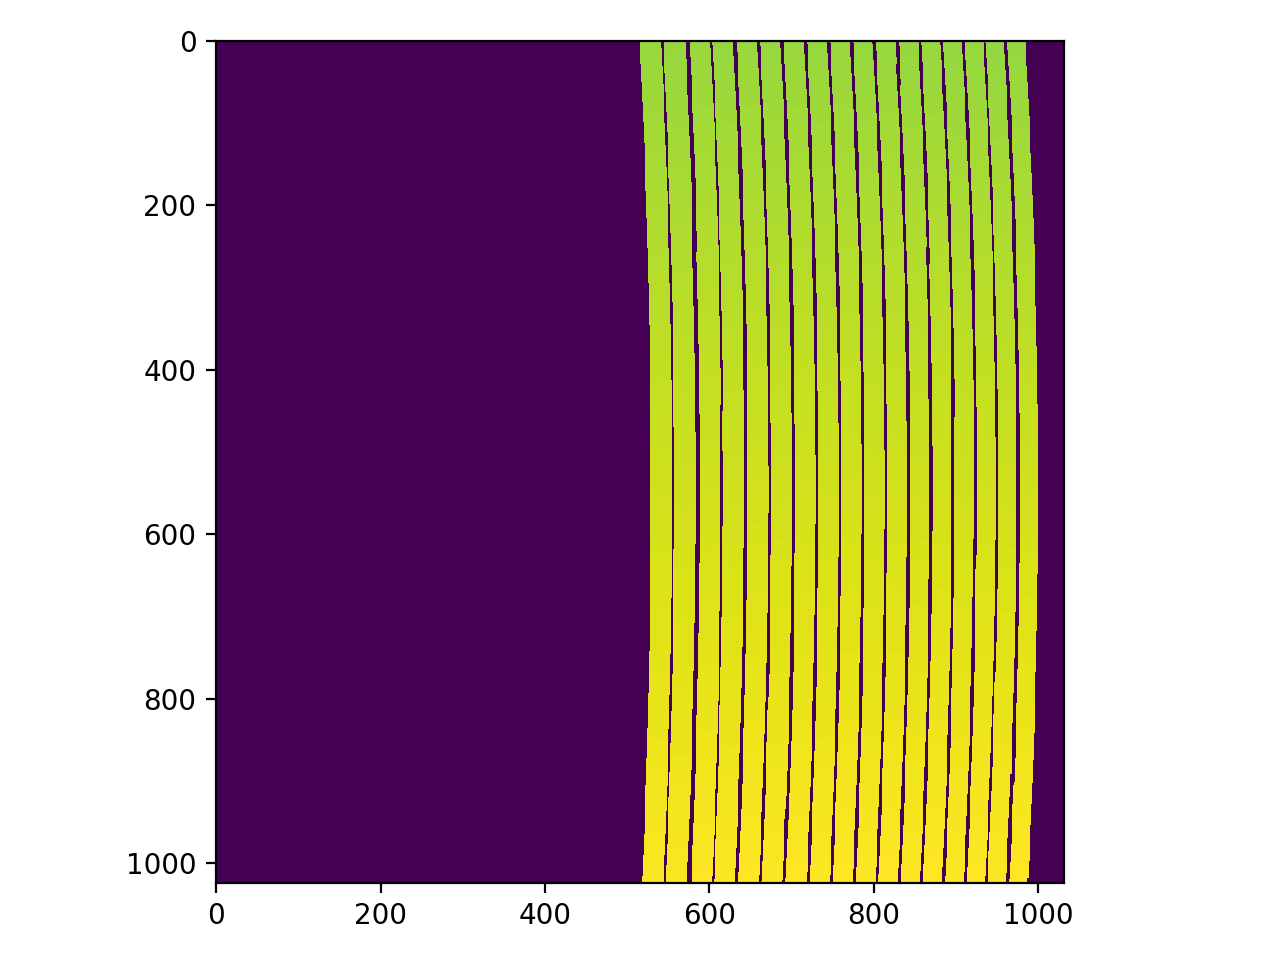

<IPython.core.display.Javascript object>


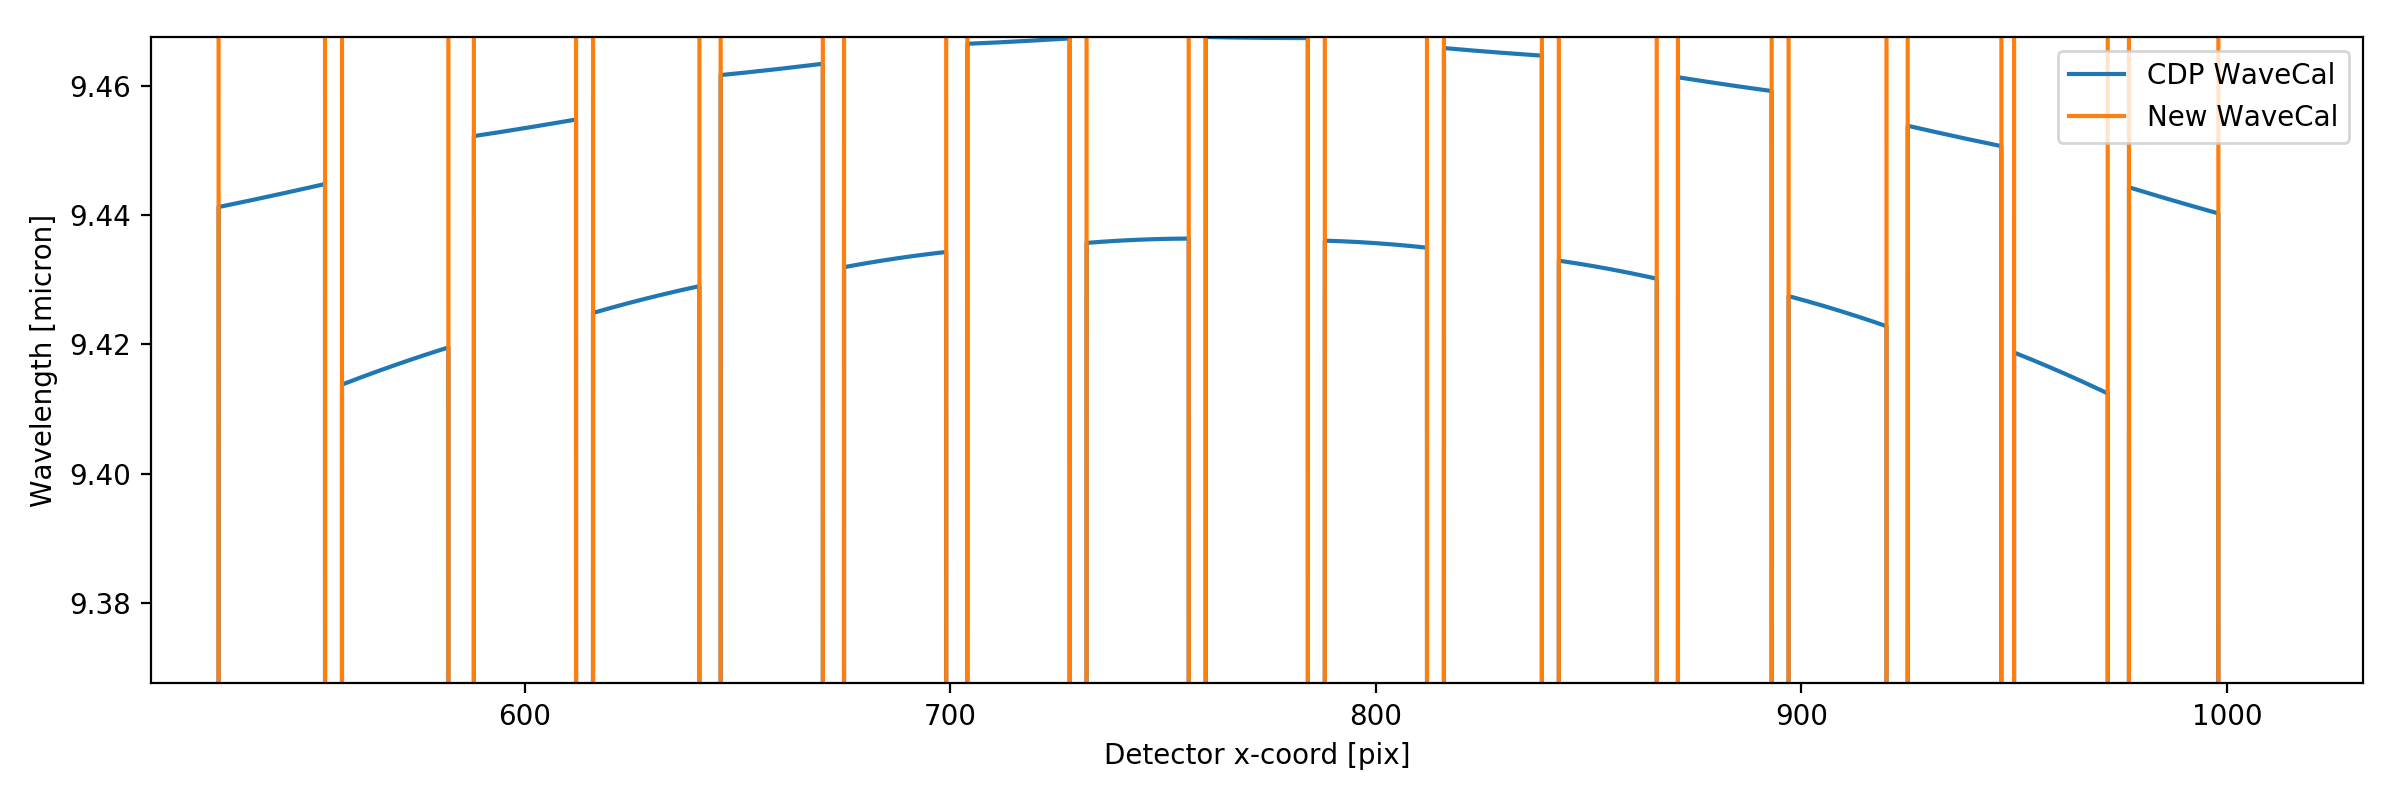

<IPython.core.display.Javascript object>


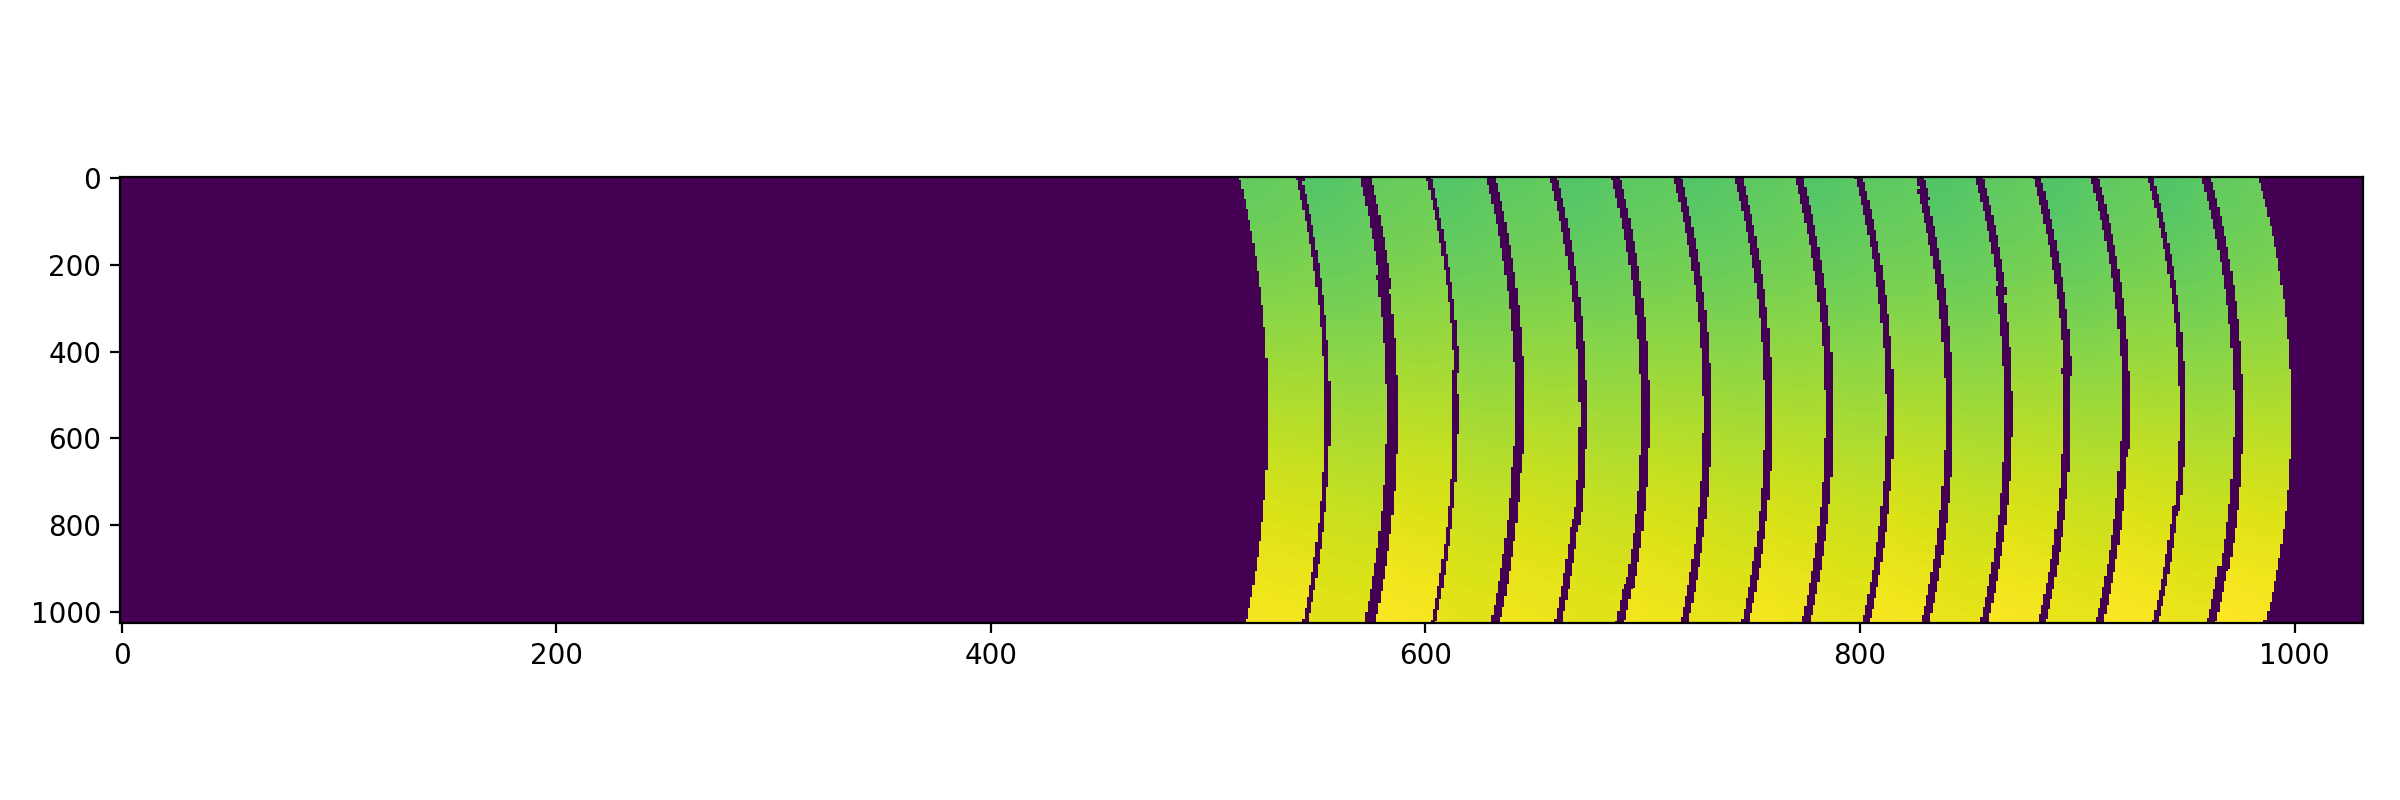

In [8]:
plt.figure()
plt.imshow(new_lambdaMap)
plt.tight_layout()

row = 512
plt.figure(figsize=(12,4))
if band[0] in ['1','4']:
    plt.plot(lambdaMap[row,:],label='CDP WaveCal')
    plt.plot(new_lambdaMap[row,:],label='New WaveCal')
    plt.xlim(0,512)
    plt.ylim(lambdaMap[row,:512].max()-0.1,lambdaMap[row,:512].max())
elif band[0] in ['2','3']:
    plt.plot(lambdaMap[row,:],label='CDP WaveCal')
    plt.plot(new_lambdaMap[row,:],label='New WaveCal')
    plt.xlim(512,1032)
    plt.ylim(lambdaMap[row,512:].max()-0.1,lambdaMap[row,512:].max())
plt.xlabel('Detector x-coord [pix]')
plt.ylabel('Wavelength [micron]')
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.imshow(new_lambdaMap-lambdaMap,aspect=0.2)
plt.tight_layout()

<IPython.core.display.Javascript object>


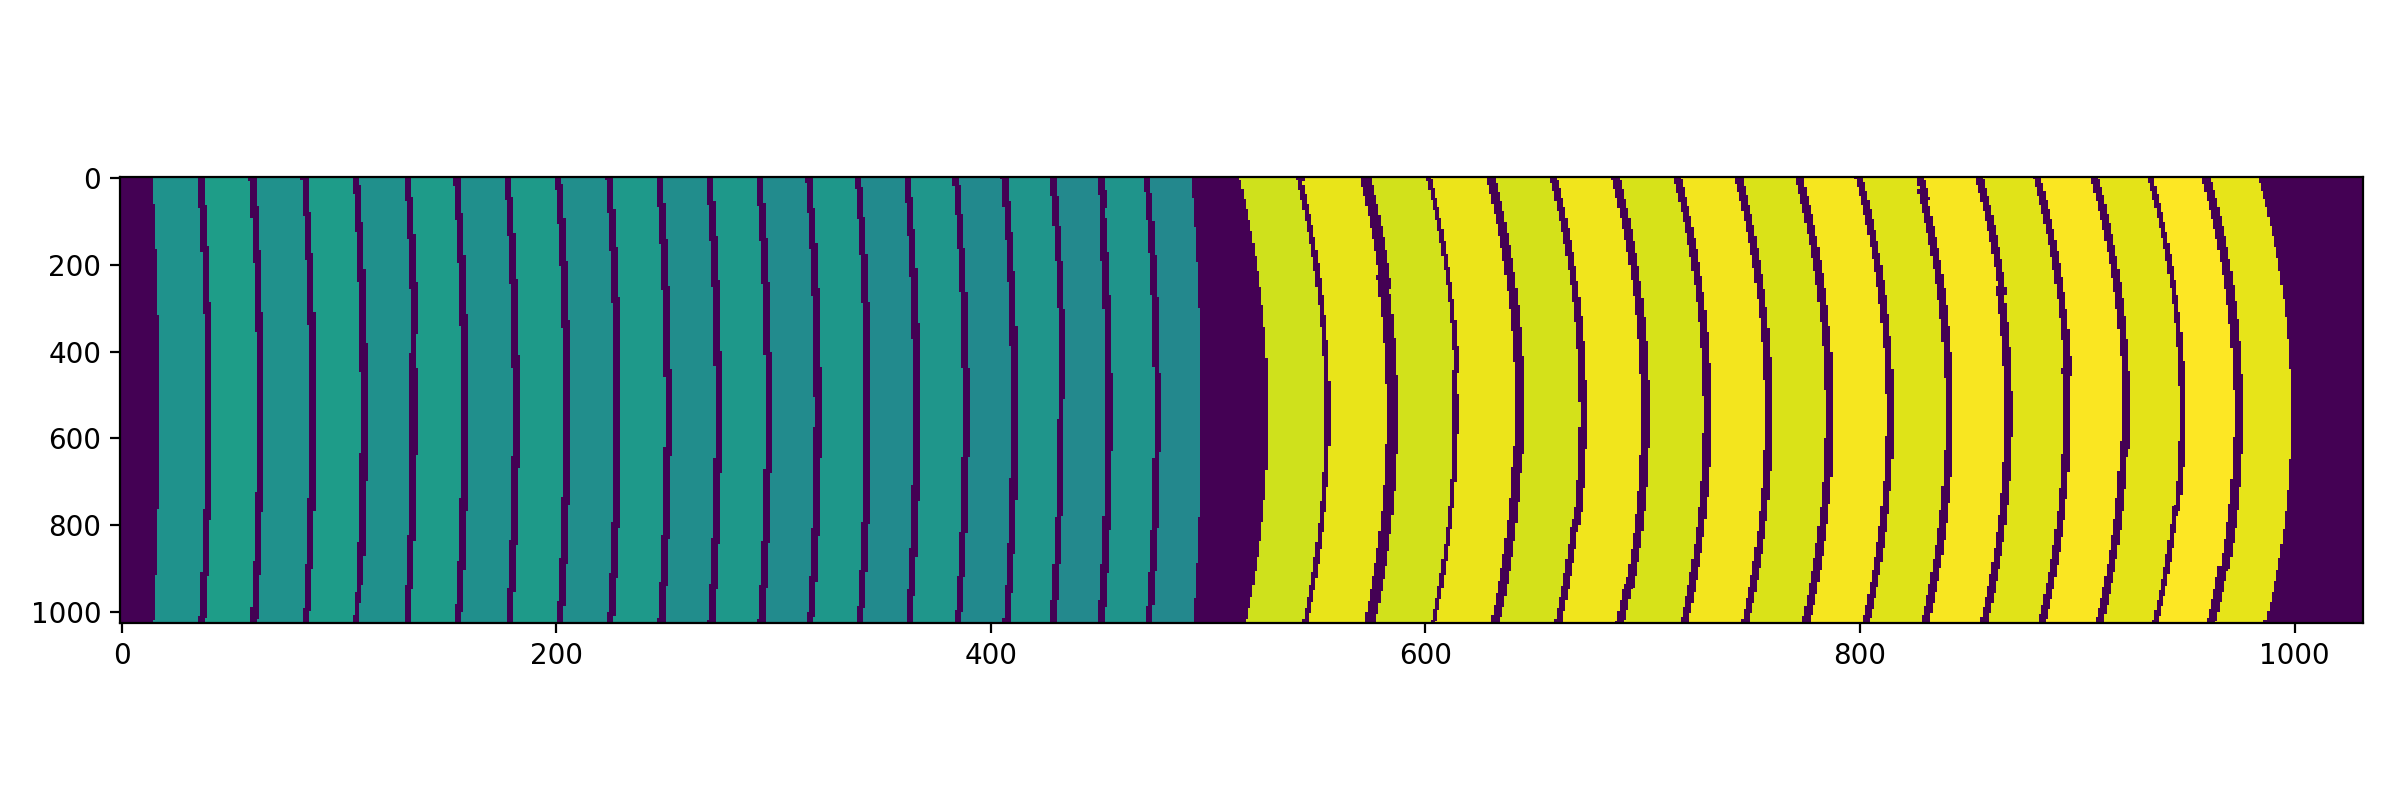

In [9]:
plt.figure(figsize=(12,4))
plt.imshow(sliceMap,aspect=0.2)
plt.tight_layout()